In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import xpress as xp
import os, hashlib
import matplotlib.pyplot as plt


xp.init("C:/Users/s2667242/AppData/Local/anaconda3/Lib/site-packages/xpress/license/xpauth.xpr")


In [2]:


# ——— 1. Parameter settings ———
tickers = [
    "AAPL","MSFT","GOOGL","AMZN","META","TSLA","JNJ","JPM","V","PG",
    "NVDA","DIS","UNH","HD","MA","PFE","BAC","KO","XOM","CVX"
]
start_date = "2020-01-01"
end_date   = "2025-07-24"

# ——— 2. Download price and volume data ———
data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    progress=False
)

# ——— 3. Extract closing price and volume (note: Adj Close for profit; Close for USD volume) ———
prices_adj = data["Adj Close"]         # 用于收益
prices_raw = data["Close"]             # 未复权价，用于美元成交额
volumes    = data["Volume"]            # DataFrame (T×d)

# ——— 4. Calculate daily simple return, average return, and covariance ———
returns = prices_adj.pct_change().dropna()   # 用复权价
mean_daily_returns = returns.mean()          # Series, 长度 d
cov_matrix         = returns.cov()           # DataFrame d×d

print("Average daily income (top 5):")
print(mean_daily_returns.head())
print("\nDaily covariance matrix (first 3×3):")
print(cov_matrix.iloc[:3, :3])

# ——— 5. Daily volatility σ and ADV (average daily USD turnover) 
sigma_all  = returns.std(axis=0).values
# Upward and downward volatility (for γ±)
up_returns   = returns.clip(lower=0)
down_returns = (-returns).clip(lower=0)
sigma_plus   = up_returns.std(axis=0).values
sigma_minus  = down_returns.std(axis=0).values

#ADV: Daily USD turnover (unadjusted Close × Volume), aligned with returns
dollar_vol = (prices_raw.reindex_like(volumes) * volumes).loc[returns.index]
Vbar = dollar_vol.mean(axis=0).values     # shape=(d,)

# ===== Auxiliary functions: ILLIQ calibration, Gershgorin upper bound, delta inversion =====
def winsorize_ser(s: pd.Series, q=0.995):
    lo, hi = s.quantile(1-q), s.quantile(q)
    return s.clip(lower=lo, upper=hi)

def estimate_kappa_from_illiq(prices_raw: pd.DataFrame,
                              volumes: pd.DataFrame,
                              returns: pd.DataFrame,
                              sigma_vec, side="both"):
    """
    ILLIQ_t = |r_t| / DollarVol_t, DollarVol_t = raw_close_t * volume_t
    κ ≈ median(ILLIQ) * ADV$ / σ
    """
    px_raw = prices_raw.loc[returns.index]
    vol    = volumes.loc[returns.index]
    dollar_vol = (px_raw * vol).replace(0, np.nan)

    illiq = (returns.abs() / dollar_vol).replace([np.inf, -np.inf], np.nan)
    if side == "plus":
        mask = (returns > 0)
    elif side == "minus":
        mask = (returns < 0)
    else:
        mask = pd.DataFrame(True, index=returns.index, columns=returns.columns)

    illiq_med = illiq.where(mask).median(axis=0, skipna=True)
    illiq_med = winsorize_ser(illiq_med, q=0.995)

    # Here we use the average of daily US dollar trading volume as ADV$
    Vbar_local = (px_raw * vol).mean(axis=0)
    sigma = pd.Series(sigma_vec, index=returns.columns)

    kappa = (illiq_med * Vbar_local / sigma).replace([np.inf, -np.inf], np.nan)
    kappa = kappa.clip(lower=0.01, upper=100.0) 
    return kappa.values  # numpy

def gershgorin_delta_max(gamma: np.ndarray, corr: np.ndarray):
    G = np.sqrt(np.outer(gamma, gamma))
    A = np.abs(corr) * G
    row_sum_off = A.sum(axis=1) - np.diag(A)
    row_sum_off = np.where(row_sum_off <= 1e-12, np.inf, row_sum_off)
    return float(np.min(gamma / row_sum_off))

def delta_from_ratio(gamma: np.ndarray, corr: np.ndarray, rho=0.3, cap_ratio=0.9):
    G = np.sqrt(np.outer(gamma, gamma))
    A = np.abs(corr) * G
    row_sum_off = A.sum(axis=1) - np.diag(A)
    factor = row_sum_off / gamma
    mean_factor = np.mean(factor[np.isfinite(factor) & (factor > 0)])
    delta_star = rho / mean_factor if (mean_factor is not None and mean_factor > 0) else 0.0
    delta_max  = gershgorin_delta_max(gamma, corr)
    return float(min(delta_star, cap_ratio * delta_max)), float(delta_max)

# ——— 6. ILLIQ calibrates κ± and back-derives γ± (unit: 1/USD) ———
kappa_plus_hat  = estimate_kappa_from_illiq(prices_raw, volumes, returns, sigma_plus,  side="plus")
kappa_minus_hat = estimate_kappa_from_illiq(prices_raw, volumes, returns, sigma_minus, side="minus")

gamma_plus  = kappa_plus_hat  * sigma_plus  / Vbar
gamma_minus = kappa_minus_hat * sigma_minus / Vbar

print("kappa+:", np.round(kappa_plus_hat[:5], 6))
print("kappa-（:", np.round(kappa_minus_hat[:5], 6))
print("gamma+ :", np.median(gamma_plus), "  gamma- :", np.median(gamma_minus))

# ——— 7. Correlation coefficient matrix corr (as usual) ———
corr = cov_matrix.values / np.outer(sigma_all, sigma_all)

# ——— 8. Estimate δ ± (mean off/diag ratio + Gershgorin upper bound) ———
delta_plus,  delta_plus_max  = delta_from_ratio(gamma_plus,  corr, rho=0.3, cap_ratio=0.9)
delta_minus, delta_minus_max = delta_from_ratio(gamma_minus, corr, rho=0.3, cap_ratio=0.9)
print(f"[delta] +: {delta_plus:.6f} (max {delta_plus_max:.6f}) ; "
      f"-: {delta_minus:.6f} (max {delta_minus_max:.6f})")

# ——— 9. Construct Ω± and perform unified “bps calibration and scaling” ———
Gp = np.sqrt(np.outer(gamma_plus,  gamma_plus))
Gm = np.sqrt(np.outer(gamma_minus, gamma_minus))
Omega_plus  = np.diag(gamma_plus)  + delta_plus  * (Gp * corr)
Omega_minus = np.diag(gamma_minus) + delta_minus * (Gm * corr)

# ——Adjust the "transaction cost xi% ADV" to target_bps（）——
xi = 0.10         # 10% ADV 
target_bps = 100   # 
c = target_bps / 1e4

s_cand_p = 2*c / np.maximum(gamma_plus  * xi * Vbar, 1e-30)
s_cand_m = 2*c / np.maximum(gamma_minus * xi * Vbar, 1e-30)
s_omega  = float(np.median(np.concatenate([s_cand_p, s_cand_m])))

Omega_plus  = s_omega * Omega_plus
Omega_minus = s_omega * Omega_minus

print(f"[Ω scale] s_omega = {s_omega:.2e}  (xi={xi:.0%}, target={target_bps}bps)")

# —— SPD check—— #
eig_p = np.linalg.eigvalsh(Omega_plus)
eig_m = np.linalg.eigvalsh(Omega_minus)
print("[Ω SPD] min eig + / - :", eig_p.min(), eig_m.min())

=


日度平均收益（前5）:
Ticker
AAPL    0.000984
AMZN    0.000886
BAC     0.000560
CVX     0.000587
DIS     0.000107
dtype: float64

日度协方差矩阵（前3×3）:
Ticker      AAPL      AMZN       BAC
Ticker                              
AAPL    0.000418  0.000279  0.000197
AMZN    0.000279  0.000514  0.000159
BAC     0.000197  0.000159  0.000495
kappa+（前5）: [0.895096 0.970692 0.859863 0.811186 0.867401]
kappa-（前5）: [0.895405 0.986045 0.824762 0.798716 0.89546 ]
gamma+ 中位数: 5.767718984813104e-12   gamma- 中位数: 5.55744830253268e-12
[delta] +: 0.033721 (max 0.049720) ; -: 0.033875 (max 0.048921)
[Ω scale] s_omega = 1.83e+01  (xi=10%, target=100bps)
[Ω SPD] min eig + / - : 1.7493438704928775e-11 1.6385538663922296e-11


In [3]:

xi_chk = xi 
q = xi_chk * Vbar  

bps_p = 1e4 * (0.5 * (q @ Omega_plus  @ q)) / (q.sum())
bps_m = 1e4 * (0.5 * (q @ Omega_minus @ q)) / (q.sum())
print(f"[check static] implied bps at {xi_chk:.0%} ADV: +{bps_p:.2f} / -{bps_m:.2f} ; target={target_bps}bps")


[check static] implied bps at 10% ADV: +181.81 / -189.58 ; target=100bps


In [4]:

N = 10   # Number of users
d = 20   #Number of assets
# 1. 期望收益 mu_list
#Convert to NumPy array
mu_vec = mean_daily_returns.values  # shape = (20,)
mu_list = [mu_vec.copy() for _ in range(N)]

# 2.  Sigma_list
Sigma_mat = cov_matrix.values       # shape = (20,20)
Sigma_list = [Sigma_mat.copy() for _ in range(N)]

# 3. Annualized processing:
trading_days = 252
mu_annual   = mu_vec * trading_days          
Sigma_annual = Sigma_mat * trading_days      

mu_list   = [mu_annual.copy() for _ in range(N)]
Sigma_list = [Sigma_annual.copy() for _ in range(N)]



In [5]:
# ——— 3.Risk aversion coefficient γ_k (N(0,1) sampling truncated to [0,1], seed=42) ———
gamma_list = [
    0.49671415,  # γ₁
    0.64768854,  # γ₂
    0.76743473,  # γ₃
    0.54256004,  # γ₄
    0.24196227,  # γ₅
    0.31424733,  # γ₆
    0.06752820,  # γ₇
    0.11092259,  # γ₈
    0.37569802,  # γ₉
    0.82254491   # γ₁₀
]

budgets = [1e6, 5e5, 8e5, 1.2e6, 6e5, 9e5, 7e5, 4e5, 1.5e6, 1e6]
# === Unified calibration risk price theta_list===
alpha = 0.5  # Target: Average |Risk| ≈ 0.5 × Average |Revenue|
w_pct0 = np.full((N, d), 1.0/d)  

risk_proto = np.array([
    0.5 * gamma_list[n] * (budgets[n]**2) * (w_pct0[n] @ Sigma_list[n] @ w_pct0[n])
    for n in range(N)
])  

rev_est = np.array([
    budgets[n] * (mu_list[n] @ w_pct0[n])  
    for n in range(N)
])

eps = 1e-12
s = (alpha * max(rev_est.mean(), eps)) / max(risk_proto.mean(), eps)
theta_list = (s * np.array(gamma_list)).tolist()
print(f"[theta] s={s:.3e}; theta in [{min(theta_list):.2e}, {max(theta_list):.2e}] 1/USD/yr")



[theta] s=9.222e-06; theta in [6.23e-07, 7.59e-06] 1/USD/yr


In [6]:

# ——— Global Model ———
model = xp.problem()

# 1)Define all variables: w[n][j], wp[n][j], wm[n][j]
w  = [[model.addVariable(lb=0.0, ub=budgets[n]) for j in range(d)] for n in range(N)]
wp = [[model.addVariable(lb=0.0, ub=budgets[n]) for j in range(d)] for n in range(N)]
wm = [[model.addVariable(lb=0.0, ub=budgets[n]) for j in range(d)] for n in range(N)]
w_pct = [[model.addVariable(lb=0.0, ub=1.0) for j in range(d)] for n in range(N)]

In [7]:
# ---------- Initial position----------

INIT_HOLDINGS_PATH = "initial_holdings.csv" 
INIT_SEED = 12345                            

def _dirichlet_like_from_hash(tickers, budgets, seed=INIT_SEED):
    
    N = len(budgets); d = len(tickers)
    W = np.zeros((N, d), dtype=float)
    for n in range(N):
        e = np.empty(d, dtype=float)
        for j, t in enumerate(tickers):
            key = f"{seed}|acct={n}|ticker={t}".encode()
            h = hashlib.sha256(key).digest()
            u64 = int.from_bytes(h[:8], "big")
            u = (u64 + 0.5) / 2**64         # map to (0,1)
            u = min(max(u, 1e-12), 1-1e-12) # 保证不开到 0/1
            e[j] = -np.log(u)               # Exp(1)
        w = e / e.sum()
        W[n, :] = w
    B = np.asarray(budgets, dtype=float)[:, None]
    return W * B  

def _load_or_make_initial_holdings(tickers, budgets, path=INIT_HOLDINGS_PATH, seed=INIT_SEED):
    if os.path.exists(path):
        df = pd.read_csv(path, index_col=0)
       
        ok_shape = (df.shape[0] == len(budgets)) and (df.shape[1] == len(tickers))
        ok_cols  = list(df.columns) == list(tickers)
        if ok_shape and ok_cols:
            return df.values
        else:
            print(f"[init] If the old file is found to have inconsistent shape or columns, regenerate and overwrite it：{path}")
    
    arr = _dirichlet_like_from_hash(tickers, budgets, seed=seed)
    df = pd.DataFrame(arr, index=[f"Acct {i}" for i in range(len(budgets))], columns=tickers)
    df.to_csv(path, float_format="%.6f")
    print(f"[init] The initial position has been generated and written：{path}")
    return arr


old_holdings = _load_or_make_initial_holdings(tickers, budgets)


In [1]:
np.random.seed(42)                  
tau = np.random.binomial(1, 0.5,    
                        size=(N, d))
tau = np.ones((10,20), dtype=int)

# tau = np.ones((N, d), dtype=int)

print("tau shape:", tau.shape)
print(tau)


NameError: name 'np' is not defined

In [9]:
# ——— New: Information pool variables ˜w⁺, ˜w⁻ —
w_plus  = [[model.addVariable(lb=0.0, ub=budgets[n]) for j in range(d)] for n in range(N)]
w_minus = [[model.addVariable(lb=0.0, ub=budgets[n]) for j in range(d)] for n in range(N)]

# Linearize [w - old_holdings]⁺/⁻
for n in range(N):
    for j in range(d):
        # w[n][j] - old_holdings[n][j] = w_plus[n][j] - w_minus[n][j]
        model.addConstraint(w_plus[n][j] - w_minus[n][j]
                            == w[n][j] - old_holdings[n][j])


In [10]:

   
# ——— 3) Each account's full position constraint ∑_j w[n][j] == budgets[n] ———
for n in range(N):
    model.addConstraint(xp.Sum(w[n][j] for j in range(d)) == budgets[n])
    

for n in range(N):
    for j in range(d):
        # w[n][j] = budgets[n] * w_pct[n][j]
        model.addConstraint(w[n][j] == budgets[n] * w_pct[n][j])

# Weighted Full Position
for n in range(N):
    model.addConstraint(xp.Sum(w_pct[n][j] for j in range(d)) == 1)



In [11]:
# ——— Sector stock subscript ———
sector_idxs = {
    "T":  [tickers.index(t) for t in ["AAPL","MSFT","NVDA"]],                          # information Technology
    "C":  [tickers.index(t) for t in ["GOOGL","META","DIS"]],                          # Content and Entertainment
    "R":  [tickers.index(t) for t in ["AMZN","HD","TSLA"]],                            # Retail and Automotive
    "H":  [tickers.index(t) for t in ["JNJ","UNH","PFE"]],                             #medicalhealth
    "F":  [tickers.index(t) for t in ["JPM","BAC","V","MA"]],                          #financialservices
    "S":  [tickers.index(t) for t in ["PG","KO"]],                                     # Consumer staples
    "E":  [tickers.index(t) for t in ["XOM","CVX"]],                                   #energy
}
#  ——— 3.1) Personalized User Constraints ———
# User 0: Conservative, Consumer Necessities + Healthcare ≥ 40%, Technology + Retail ≤ 25%
model.addConstraint(xp.Sum(w[0][j] for j in sector_idxs["S"]+sector_idxs["H"]) >=  budgets[0]*0.40)
model.addConstraint(xp.Sum(w[0][j] for j in sector_idxs["T"]+sector_idxs["R"]) <=  budgets[0]*0.25)

# User 1: Aggressive growth type, technology ≥40%, content + AMZN ≥30%
model.addConstraint(xp.Sum(w[1][j] for j in sector_idxs["T"]) >=  budgets[1]*0.40)
model.addConstraint(xp.Sum(w[1][j] for j in sector_idxs["C"] + [tickers.index("AMZN")]) >=  budgets[1]*.30)

# User 2: Balanced, with upper and lower limits for each sector
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["T"]) >=  budgets[2]*0.10)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["T"]) <= budgets[2]*0.25)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["C"]) >= budgets[2]*0.10)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["C"]) <= budgets[2]*0.25)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["H"]) >= budgets[2]*0.10)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["H"]) <= budgets[2]*0.25)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["F"]) >= budgets[2]*0.10)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["F"]) <= budgets[2]*0.25)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["S"]+sector_idxs["E"]) >= budgets[2]*0.05)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["S"]+sector_idxs["E"]) <= budgets[2]*0.15)

# User 3: Income type, consumer essentials + finance + energy ≥ 50%, finance ≥ 20%
model.addConstraint(xp.Sum(w[3][j] for j in sector_idxs["S"]+sector_idxs["F"]+sector_idxs["E"]) >= budgets[3]*0.50)
model.addConstraint(xp.Sum(w[3][j] for j in sector_idxs["F"]) >= budgets[3]*0.20)

# User 4: Theme Rotation, Energy ≥15%, Finance ≥25%
model.addConstraint(xp.Sum(w[4][j] for j in sector_idxs["E"]) >= budgets[4]*0.15)
model.addConstraint(xp.Sum(w[4][j] for j in sector_idxs["F"]) >= budgets[4]*0.25)

# User 5: Technology + Healthcare, Technology ≥30%, Healthcare ≥20%, Consumption + Retail ≤15%
model.addConstraint(xp.Sum(w[5][j] for j in sector_idxs["T"]) >= budgets[5]*0.30)
model.addConstraint(xp.Sum(w[5][j] for j in sector_idxs["H"]) >= budgets[5]*0.20)
model.addConstraint(xp.Sum(w[5][j] for j in sector_idxs["S"]+sector_idxs["R"]) <= budgets[5]*0.15)

# User 6: Value, Growth sector ≤35%, Energy + Finance + Consumer Staples ≥40%
growth6 = sector_idxs["T"] + sector_idxs["C"] + sector_idxs["R"]
model.addConstraint(xp.Sum(w[6][j] for j in growth6) <= budgets[6]*0.35)
model.addConstraint(xp.Sum(w[6][j] for j in sector_idxs["E"]+sector_idxs["F"]+sector_idxs["S"]) >= budgets[6]*0.40)

# User 7: Small-cap preference (AMZN, TSLA) ≥30%, large-cap preference ≤50%
model.addConstraint(xp.Sum(w[7][j] for j in [tickers.index("AMZN"), tickers.index("TSLA")]) >= budgets[7]*0.30)
model.addConstraint(xp.Sum(w[7][j] for j in sector_idxs["T"]+sector_idxs["F"]+sector_idxs["H"]) <= budgets[7]*0.50)

# User 8: High growth preference NVDA, TSLA, AAPL, MSFT ≥ 50%
growth8 = [tickers.index(t) for t in ["NVDA","TSLA","AAPL","MSFT"]]
model.addConstraint(xp.Sum(w[8][j] for j in growth8) >= budgets[8]*0.50)

# User 9: Defense + Growth Balance, Defense (S+E) ≥ 20%, Growth (T+C+R) ≥ 30%
model.addConstraint(xp.Sum(w[9][j] for j in sector_idxs["S"]+sector_idxs["E"]) >= budgets[9]*0.20)
model.addConstraint(xp.Sum(w[9][j] for j in sector_idxs["T"]+sector_idxs["C"]+sector_idxs["R"]) >= budgets[9]*0.30)


In [14]:
lin = xp.Sum(mu_list[n][j] * w[n][j]
             for n in range(N) for j in range(d))

risk = xp.Sum(
    -0.5 * theta_list[n] * (budgets[n]**2) *
    xp.Sum(Sigma_list[n][i][j] * w_pct[n][i] * w_pct[n][j] for i in range(d) for j in range(d))
    for n in range(N)
)


# —— pooled sums ——  
T_plus  = [xp.Sum(tau[k, j] * w_plus[k][j]  for k in range(N)) for j in range(d)]
T_minus = [xp.Sum(tau[k, j] * w_minus[k][j] for k in range(N)) for j in range(d)]

# 0.5 * [T+;T-]^T * [[Ω+,Ω-],[Ω-,Ω+]] * [T+;T-]
quad_pp = xp.Sum(T_plus[i]  * xp.Sum(Omega_plus[i,  j] * T_plus[j]  for j in range(d)) for i in range(d))
quad_mm = xp.Sum(T_minus[i] * xp.Sum(Omega_plus[i,  j] * T_minus[j] for j in range(d)) for i in range(d))
cross_pm = xp.Sum(T_plus[i] * xp.Sum(Omega_minus[i, j] * T_minus[j] for j in range(d)) for i in range(d))
impact_pool = 0.5 * (quad_pp + quad_mm + 2 * cross_pm)

# —— independent accounts (each runs alone on assets with tau=0) ——
impact_ind = 0
for m in range(N):
    r_p = [ (1 - tau[m, j]) * w_plus[m][j]  for j in range(d) ]
    r_m = [ (1 - tau[m, j]) * w_minus[m][j] for j in range(d) ]
    quad_pp_m = xp.Sum(r_p[i] * xp.Sum(Omega_plus[i,  j] * r_p[j] for j in range(d)) for i in range(d))
    quad_mm_m = xp.Sum(r_m[i] * xp.Sum(Omega_plus[i,  j] * r_m[j] for j in range(d)) for i in range(d))
    cross_pm_m = xp.Sum(r_p[i] * xp.Sum(Omega_minus[i, j] * r_m[j] for j in range(d)) for i in range(d))
    impact_ind += 0.5 * (quad_pp_m + quad_mm_m + 2 * cross_pm_m)

impact = - trading_days * (impact_pool + impact_ind)

# Objective
model.setObjective(lin + risk + impact, sense=xp.maximize)


In [15]:

# 6) solve
model.solve()

# 7) solution
solutions = []
for n in range(N):
    w_opt = [model.getSolution(w[n][j]) for j in range(d)]
    solutions.append(w_opt)
    print(f"Account {n} optimal w:", w_opt)


FICO Xpress v9.5.0, Hyper, solve started 0:31:11, Aug 18, 2025
Heap usage: 3389KB (peak 6681KB, 85KB system)
Maximizing QP noname using up to 8 threads and up to 15GB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = -1
Original problem has:
       448 rows         1200 cols         1527 elements
    164000 qobjelem
Presolved problem has:
       233 rows          600 cols          910 elements
    164000 qobjelem
Presolve finished in 0 seconds
Heap usage: 6047KB (peak 6681KB, 85KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.50e+06] / [ 1.00e+00,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.50e+06] / [ 8.24e+01,  1.50e+06]
  Objective      [min,max] : [ 1.31e-02,  7.54e-01] / [ 1.31e-02,  7.54e-01]
  Quadratic      [min,max] : [ 2.47e-11,  3.60e+06] / [ 2.47e-11,  3.50e-06]
Autoscaling applied standard scaling

Using AVX2 support
Core

[diag] true total annual impact = 77,455.369043 ; C-split total = 140,190.505756 ; gap = 62,735.136713
[diag] pooled C-split sum - true pooled cost (daily) = 248.948955
[CHECK] rebuilt objective = 2,079,400.46 ; model objective = 2,142,135.60 ; Δ=-62,735.14
[check static] single-side bps at 10% ADV: 181.81
[check static] two-sided (with cross) bps: 371.39
[check dynamic] true annualized impact=$77,455 (bps≈70.38) ; C-split annualized=$140,191 (bps≈127.39)
              Revenue    Risk Penalty  Transaction Cost    Net Utility
Acct 0 389,905.299146 -180,938.394476     13,895.319410 195,071.585260
Acct 1 197,297.731818  -81,378.003454      8,933.322933 106,986.405431
Acct 2 307,194.867284 -175,375.623344     10,763.246690 121,055.997249
Acct 3 472,544.975999 -267,105.031575     18,141.908130 187,298.036294
Acct 4 388,718.459231  -80,505.824778     13,018.187227 295,194.447225
Acct 5 400,674.713307 -156,585.657299     12,197.760771 231,891.295237
Acct 6 490,683.910765  -47,635.884077     1

C:\Users\s2667242\AppData\Local\Temp\ipykernel_3936\2870444756.py:151: DeprecationWarning: Deprecated in Xpress 9.5: use problem.attributes.objval instead
  obj_model = model.getObjVal()


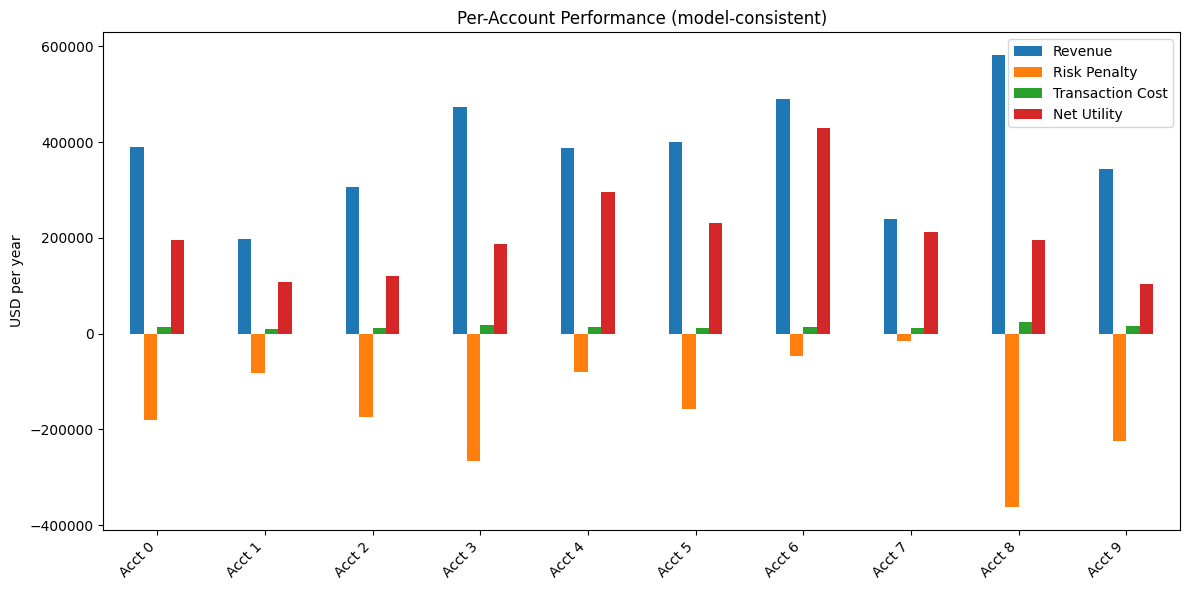

In [16]:


# =========================
# 0) Pre-checks (avoid mismatches)
# =========================
if 'theta_list' not in globals():
    raise RuntimeError("theta_list 未定义：请在建模前完成风险价格标定，并将 theta_list 传入。")
if 'Omega_plus' not in globals() or 'Omega_minus' not in globals():
    raise RuntimeError("Omega_plus / Omega_minus 未定义：请先完成Ω构造与标定。")

# =========================
# 1) Retrieve optimal solution from the model
# =========================
solutions    = np.zeros((N, d))
w_plus_vals  = np.zeros((N, d))
w_minus_vals = np.zeros((N, d))

for n in range(N):
    for j in range(d):
        solutions[n, j]    = model.getSolution(w[n][j])
        w_plus_vals[n, j]  = model.getSolution(w_plus[n][j])
        w_minus_vals[n, j] = model.getSolution(w_minus[n][j])

tau_arr     = np.asarray(tau, dtype=int)        # N×d binary trade indicator
budgets_arr = np.asarray(budgets, dtype=float)  # length-N budgets
theta       = np.asarray(theta_list, dtype=float)

# =========================
# 2) Compute performance components
# =========================
# 2.0 Portfolio weights (allocation shares)
w_pct = solutions / budgets_arr[:, None]  # shape N×d

# 2.1 Expected returns (USD per year)
revenues = np.array([mu_list[n] @ solutions[n] for n in range(N)])  # length N

# 2.2 Risk penalty (USD per year)
risk_penalty = np.array([
    -0.5 * theta[n] * (budgets_arr[n]**2) *
    (w_pct[n] @ Sigma_list[n] @ w_pct[n])
    for n in range(N)
])

# 2.3 Transaction costs (USD per year): pooled + independent

# compute pooled trades
q_plus   = tau_arr * w_plus_vals   # N×d
q_minus  = tau_arr * w_minus_vals  # N×d
T_plus   = q_plus.sum(axis=0)      # d
T_minus  = q_minus.sum(axis=0)     # d

# pooled cost linear term
term_linear = (
    (q_plus  @ Omega_plus  @ T_plus)  # N-length
  + (q_minus @ Omega_plus  @ T_minus)
  + (q_plus  @ Omega_minus @ T_minus)
  + (q_minus @ Omega_minus @ T_plus)
)

# pooled self-quadratic term
self_quad = 0.5 * (
    np.einsum('ni,ij,nj->n', q_plus,  Omega_plus,  q_plus)
  + np.einsum('ni,ij,nj->n', q_minus, Omega_plus,  q_minus)
  + 2.0 * np.einsum('ni,ij,nj->n', q_plus,  Omega_minus, q_minus)
)

C_pooled = term_linear - self_quad  # length N

# independent cost (for tau==0 trades)
C_ind = np.zeros(N)
for n in range(N):
    r_p = (1 - tau_arr[n]) * w_plus_vals[n]
    r_m = (1 - tau_arr[n]) * w_minus_vals[n]
    C_ind[n] = 0.5 * (
        r_p @ Omega_plus  @ r_p
      + r_m @ Omega_plus  @ r_m
      + 2.0 * (r_p @ Omega_minus @ r_m)
    )

transaction_costs = trading_days * (C_pooled + C_ind)

# 2.4 Net utility
net_utility = revenues + risk_penalty - transaction_costs

# =========================
# 3) Consistency diagnostics
# =========================
# 3.1 True pooled daily cost
pooled_total_daily = 0.5 * (
    T_plus  @ Omega_plus  @ T_plus +
    T_minus @ Omega_plus  @ T_minus +
    2.0 * (T_plus @ Omega_minus @ T_minus)
)

# 3.2 True independent daily cost
independent_total_daily = 0.0
for n in range(N):
    r_p = (1 - tau_arr[n]) * w_plus_vals[n]
    r_m = (1 - tau_arr[n]) * w_minus_vals[n]
    independent_total_daily += 0.5 * (
        r_p @ Omega_plus  @ r_p +
        r_m @ Omega_plus  @ r_m +
        2.0 * (r_p @ Omega_minus @ r_m)
    )

# 3.3 Annualized true vs split cost comparison
total_cost_annual_true   = trading_days * (pooled_total_daily + independent_total_daily)
total_cost_annual_csplit = transaction_costs.sum()
print(f"[diag] true annual impact = {total_cost_annual_true:,.6f} ; "
      f"split cost = {total_cost_annual_csplit:,.6f} ; "
      f"gap = {total_cost_annual_csplit - total_cost_annual_true:,.6f}")

# 3.4 Pooled split budget gap
pooled_budget_gap_daily = C_pooled.sum() - pooled_total_daily
print(f"[diag] pooled split sum - true pooled cost = {pooled_budget_gap_daily:.6f}")

# 3.5 Rebuild objective vs model
obj_rebuilt = revenues.sum() + risk_penalty.sum() - transaction_costs.sum()
try:
    obj_model = model.getObjVal()
    print(f"[CHECK] rebuilt obj = {obj_rebuilt:,.2f} ; model obj = {obj_model:,.2f} ; Δ={obj_rebuilt-obj_model:,.2f}")
except Exception:
    print(f"[CHECK] rebuilt obj = {obj_rebuilt:,.2f}")

# =========================
# 4) bps checks: static & dynamic
# =========================
# static single / two-sided cost in bps
xi_chk = globals().get('xi', 0.10)
if 'Vbar' in globals():
    q_static     = xi_chk * np.asarray(Vbar, dtype=float)
    denom1       = max(q_static.sum(), 1.0)
    bps_single   = 1e4 * (0.5 * (q_static @ Omega_plus @ q_static)) / denom1
    denom2       = max(2.0 * q_static.sum(), 1.0)
    bps_cross    = 1e4 * (0.5 * (
        q_static @ Omega_plus @ q_static +
        q_static @ Omega_plus @ q_static +
        2.0 * (q_static @ Omega_minus @ q_static)
    )) / denom2
    print(f"[check static] single-side bps: {bps_single:.2f}")
    print(f"[check static] two-sided bps: {bps_cross:.2f}")
else:
    print("[check static] Vbar missing, skipping static bps check.")

# dynamic impact in bps
T_notional     = np.abs(T_plus).sum() + np.abs(T_minus).sum()
impact_true    = total_cost_annual_true
impact_split   = total_cost_annual_csplit
bps_true       = 1e4 * impact_true  / max(T_notional, 1.0)
bps_split      = 1e4 * impact_split / max(T_notional, 1.0)
print(f"[check dynamic] true annual impact=${impact_true:,.0f} (bps≈{bps_true:.2f}) ; "
      f"split annual impact=${impact_split:,.0f} (bps≈{bps_split:.2f})")

# =========================
# 5) Visualization
# =========================
df = pd.DataFrame({
    'Revenue':           revenues,
    'Risk Penalty':      risk_penalty,
    'Transaction Cost':  transaction_costs,
    'Net Utility':       net_utility
}, index=[f'Acct {i}' for i in range(N)])

pd.set_option('display.float_format', lambda x: f"{x:,.6f}")
print(df)

ax = df.plot.bar(figsize=(12, 6))
ax.set_ylabel('USD per year')
ax.set_title('Per‐Account Performance (model‐consistent)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [17]:
df.to_csv('account_performance.csv', float_format='%.6f')
